  # Test of hierarchical classification (model 2)
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint as sp_randint
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from collections import Counter

  ### Definition of names for plots and files

In [2]:
date = '20200609'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.1.csv'

features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'


class_output = '../ZTF_classifications/xgboost_classification_unlabelled_set_with_TSvs7.0.0_'+date+'.csv'

#where the RF models are saved


model_first_layer = 'stat_xgboost/rf_model_2_hierarchical_layer_'+date
model_periodic_layer = 'stat_xgboost/rf_model_2_periodic_layer_'+date
model_transient_layer = 'stat_xgboost/rf_model_2_transient_layer_'+date
model_stochastic_layer = 'stat_xgboost/rf_model_2_stochastic_layer_'+date



conf_matrix_name_first_layer = 'stat_xgboost/confusion_matrix_rf_model_2_hierarchical_layer_'+date
conf_matrix_name_second_layer = 'stat_xgboost/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances

feature_importance_name_first_layer = 'stat_xgboost/feature_importance_rf_model_2_hierarchical_layer_'+date
feature_importance_name_periodic_layer = 'stat_xgboost/feature_importance_rf_model_2_periodic_layer_'+date
feature_importance_name_transient_layer = 'stat_xgboost/feature_importance_rf_model_2_transient_layer_'+date
feature_importance_name_stochastic_layer = 'stat_xgboost/feature_importance_rf_model_2_stochastic_layer_'+date

### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

df_feat_for_stats = df_feat.copy()
print(df_labels['class_source'].values.size)
print(df_feat.head())

173879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[(df_labels['source']!="ASASSN") & (df_labels['source']!="GAIADR2VS")]
#df_labels = df_labels[(df_labels['source']!="ASASSN") ]

bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

df_labels.drop(bad_oid,inplace=True)

df_labels = df_labels[(df_labels['class_source']!="ELL")]

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(171284,)


,class_original,class_hierachical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
#print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
#print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

#print(df['g-r_max'].values.size)
df.head()

122531


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aapcxhy,0.068704,0.052665,0.665183,0.501831,1.0,1.0,0.250000,0.307692,0.0,0.0,...,0.780000,0.013542,0.796,2.889,8.106832,5.217832,8.668390,5.779390,0.202128,1.155121
ZTF18abtmwvo,0.115177,-999.000000,0.996398,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.717857,0.216488,0.807,2.964,-999.000000,-999.000000,9.126021,6.162021,0.081005,-999.000000
ZTF18acvgdfy,0.050608,-999.000000,0.353987,-999.000000,1.0,-999.0,0.500000,-999.000000,0.0,-999.0,...,0.683333,0.088542,0.606,2.876,-999.000000,-999.000000,8.483215,5.607215,0.023222,-999.000000
ZTF19aabvjsi,-999.000000,0.028547,-999.000000,0.494246,-999.0,1.0,-999.000000,0.333333,-999.0,0.0,...,0.683333,0.035875,0.938,3.017,8.099364,5.082364,-999.000000,-999.000000,-999.000000,0.529107
ZTF18aadyxlg,-999.000000,0.021935,-999.000000,0.543918,-999.0,1.0,-999.000000,0.500000,-999.0,0.0,...,0.683333,0.161542,0.959,3.021,8.041334,5.020334,-999.000000,-999.000000,-999.000000,0.277404


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
'''def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()'''
    
    
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_hierarchical = labels['class_hierachical']
Y_original = labels['class_original']

X_hierarchical = df

le_original = LabelEncoder()
le_original.fit(Y_original.values)

class_weights_org = list(class_weight.compute_class_weight('balanced', np.unique(Y_original.values), Y_original.values))
print(class_weights_org)
w_array_org = np.ones(len(Y_original.values), dtype = 'float')

for i in range(len(class_weights_org)):
    w_array_org[np.where(le_original.transform(Y_original).astype(int)==i)]=class_weights_org[i]


#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original, w_array_org_train, w_array_org_test  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, w_array_org, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']
w_array_periodic = w_array_org[np.where(y_train_hierarchical=='Periodic')]

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']
w_array_stochastic = w_array_org[np.where(y_train_hierarchical=='Stochastic')]

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']
w_array_transient = w_array_org[np.where(y_train_hierarchical=='Transient')]




X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

le_hierarchical = LabelEncoder()

y_train_hierarchical_encoded = le_hierarchical.fit_transform(y_train_hierarchical)

y_train_periodic_encoded = le_original.transform(y_train_periodic)
y_train_stochastic_encoded = le_original.transform(y_train_stochastic)
y_train_transient_encoded = le_original.transform(y_train_transient)


print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

[1.7503178344403971, 6.447303341225993, 13.218015102481122, 9.378568694986605, 11.159471766848815, 0.21552817427860302, 0.5803305863408165, 28.071248568155784, 0.31216498522368286, 0.25148492498409375, 340.3638888888889, 24.90467479674797, 6.421960167714885, 86.90141843971631, 4.6946743295019155]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['AGN' 'Blazar' 'CEP' 'CV/Nova' 'DSCT' 'E' 'LPV' 'Periodic-Other' 'QSO'
 'RRL' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'YSO'], y=['AGN' 'AGN' 'AGN' ... 'LPV' 'LPV' 'LPV'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


68879 27771 1374


  ## Balanced XGBoost
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [8]:
#Training first layer of the RF model

exgb_hierarchical = XGBClassifier(
   max_depth=7,
   min_child_weight=1,
   learning_rate=0.1,
   n_estimators=500,
   silent=False,
   objective='multi:softmax',
   gamma=0,
   max_delta_step=0,
   subsample=0.7,
   colsample_bytree=0.7,
   reg_alpha=0,
   reg_lambda=0,
   scale_pos_weight=1,
   missing=-999,
   n_jobs=5,
)




ros = RandomUnderSampler(sampling_strategy='all')
N_samplers=20
out_sampler_X = []
out_sampler_Y = []

for i in range(N_samplers):
    X_resampled, y_resampled = ros.fit_resample(X_train_hierarchical, y_train_hierarchical_encoded)
    X_resampled_df = pd.DataFrame(X_resampled,columns=X_train_hierarchical.columns)
    out_sampler_X.append(X_resampled_df)
    out_sampler_Y.append(y_resampled)
    
df_final_X = pd.concat(out_sampler_X)
y_resampled_final=np.array(out_sampler_Y).flatten()
print(y_resampled_final)    
print(sorted(Counter(y_resampled_final).items()))


exgb_hierarchical.fit(df_final_X, y_resampled_final)


#testing first layer performance

y_true, y_pred = le_hierarchical.transform(y_test_hierarchical), exgb_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = exgb_hierarchical.predict_proba(X_test_hierarchical)



[0 0 0 ... 2 2 2]
[(0, 27480), (1, 27480), (2, 27480)]
[18:05:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [9]:
classes_order_proba_hierarchical = exgb_hierarchical.classes_
print(classes_order_proba_hierarchical)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))
print("macro precision: ", metrics.precision_score(y_true, y_pred, average='macro'))
print("macro recall: ", metrics.recall_score(y_true, y_pred, average='macro'))
print("macro F1: ", metrics.f1_score(y_true, y_pred, average='macro'))


#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'xgboost_model': exgb_hierarchical,
            'features': features_hierarchical,
            'order_classes': classes_order_proba_hierarchical
            }
        pickle.dump(model_dump, pickle_file)

[0 1 2]
Accuracy: 0.9946953931529767
Balanced accuracy: 0.9932342437747055
macro precision:  0.9932590779498485
macro recall:  0.9932342437747055
macro F1:  0.9932436695178829


[[  342     2     0]
 [    3  6860    79]
 [    0    46 17175]]
Normalized confusion matrix
[[ 99.   1.   0.]
 [  0.  99.   1.]
 [  0.   0. 100.]]


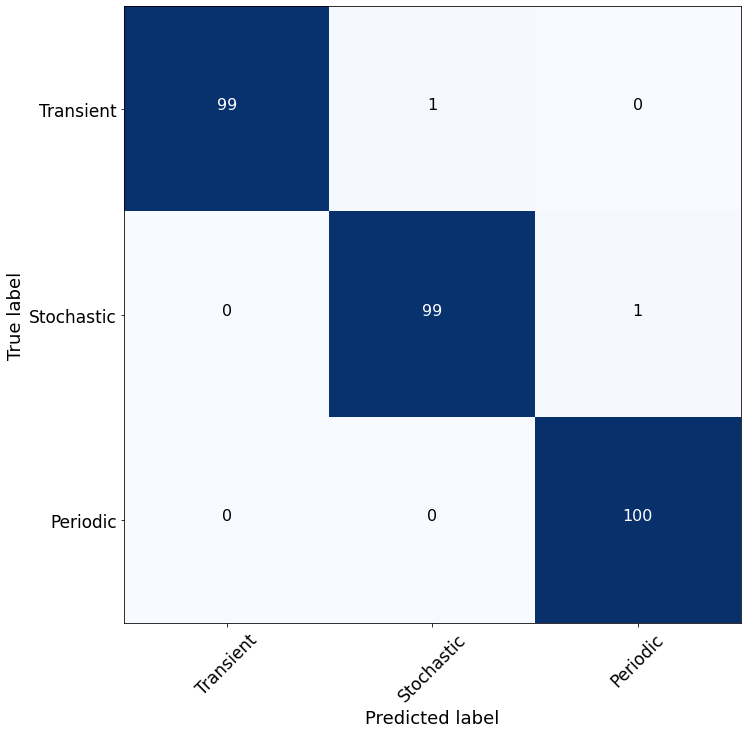

In [10]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(le_hierarchical.inverse_transform(y_true), le_hierarchical.inverse_transform(y_pred), labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,'../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_XGBoost_hierarchical.pdf')

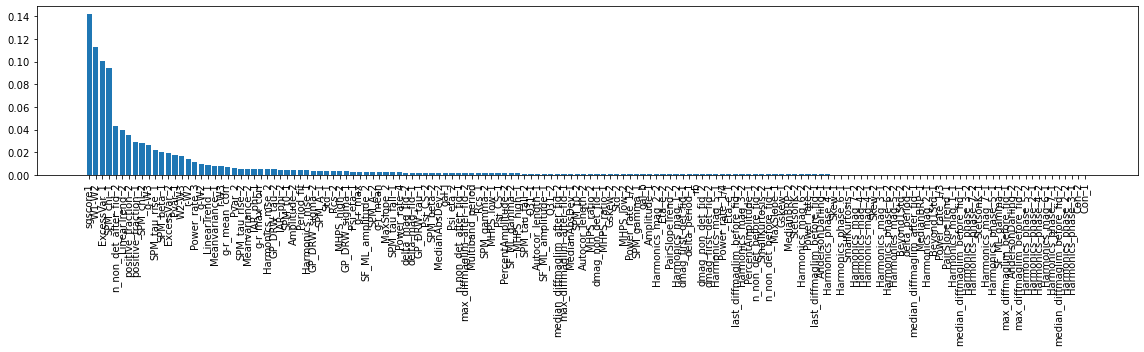

In [11]:
#plotting feature importance
plot_feature_importances(exgb_hierarchical, features_hierarchical, feature_importance_name_first_layer)

  ### Periodic layer

In [12]:
#Training Periodic layer

exgb_periodic = XGBClassifier(
   max_depth=7,
   min_child_weight=1,
   learning_rate=0.1,
   n_estimators=500,
   silent=False,
   objective='multi:softmax',
   gamma=0,
   max_delta_step=0,
   subsample=0.7,
   colsample_bytree=0.7,
   reg_alpha=0,
   reg_lambda=0,
   scale_pos_weight=1,
   missing=-999,
   n_jobs=5,
)

ros = RandomUnderSampler(sampling_strategy='all')
N_samplers=20
out_sampler_X = []
out_sampler_Y = []

for i in range(N_samplers):
    X_resampled, y_resampled = ros.fit_resample(X_train_periodic, y_train_periodic_encoded)
    X_resampled_df = pd.DataFrame(X_resampled,columns=X_train_hierarchical.columns)
    out_sampler_X.append(X_resampled_df)
    out_sampler_Y.append(y_resampled)
    
df_final_X = pd.concat(out_sampler_X)
y_resampled_final=np.array(out_sampler_Y).flatten()
print(y_resampled_final)    
print(sorted(Counter(y_resampled_final).items()))

exgb_periodic.fit(df_final_X, y_resampled_final)



# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = le_original.transform(y_test_original), exgb_periodic.predict(X_test_periodic)
y_pred_proba_periodic = exgb_periodic.predict_proba(X_test_periodic)


[2 2 2 ... 9 9 9]
[(2, 4660), (4, 4660), (5, 4660), (6, 4660), (7, 4660), (9, 4660)]
[18:12:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [13]:
classes_order_proba_periodic = exgb_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': exgb_periodic,
            'features': features_periodic,
            'order_classes': classes_order_proba_periodic
            }
        pickle.dump(model_dump, pickle_file)

[2 4 5 6 7 9]


70


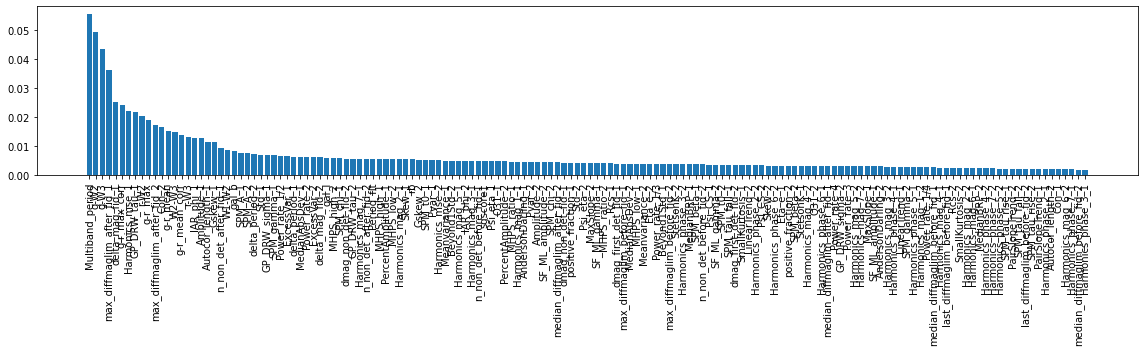

In [14]:
#plotting feature importance
print(len(feature_importance_name_first_layer))
plot_feature_importances(exgb_periodic, features_periodic, feature_importance_name_periodic_layer)

  ### Stochastic layer

In [15]:
#Training Stochastic layer

exgb_stochastic = XGBClassifier(
   max_depth=7,
   min_child_weight=1,
   learning_rate=0.1,
   n_estimators=500,
   silent=False,
   objective='multi:softmax',
   gamma=0,
   max_delta_step=0,
   subsample=0.7,
   colsample_bytree=0.7,
   reg_alpha=0,
   reg_lambda=0,
   scale_pos_weight=1,
   missing=-999,
   n_jobs=5,
)


ros = RandomUnderSampler(sampling_strategy='all')
N_samplers=20
out_sampler_X = []
out_sampler_Y = []

for i in range(N_samplers):
    X_resampled, y_resampled = ros.fit_resample(X_train_stochastic, y_train_stochastic_encoded)
    X_resampled_df = pd.DataFrame(X_resampled,columns=X_train_hierarchical.columns)
    out_sampler_X.append(X_resampled_df)
    out_sampler_Y.append(y_resampled)
    
df_final_X = pd.concat(out_sampler_X)
y_resampled_final=np.array(out_sampler_Y).flatten()
print(y_resampled_final)    
print(sorted(Counter(y_resampled_final).items()))


exgb_stochastic.fit(df_final_X, y_resampled_final)


# Applying periodic model to the test data
y_true_stochastic, y_pred_stochastic = le_original.transform(y_test_original), exgb_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = exgb_stochastic.predict_proba(X_test_stochastic)

[ 0  0  0 ... 14 14 14]
[(0, 13940), (1, 13940), (3, 13940), (8, 13940), (14, 13940)]
[18:18:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [16]:
classes_order_proba_stochastic = exgb_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': exgb_stochastic,
            'features': features_stochastic,
            'order_classes': classes_order_proba_stochastic
            }
        pickle.dump(model_dump, pickle_file)

[ 0  1  3  8 14]


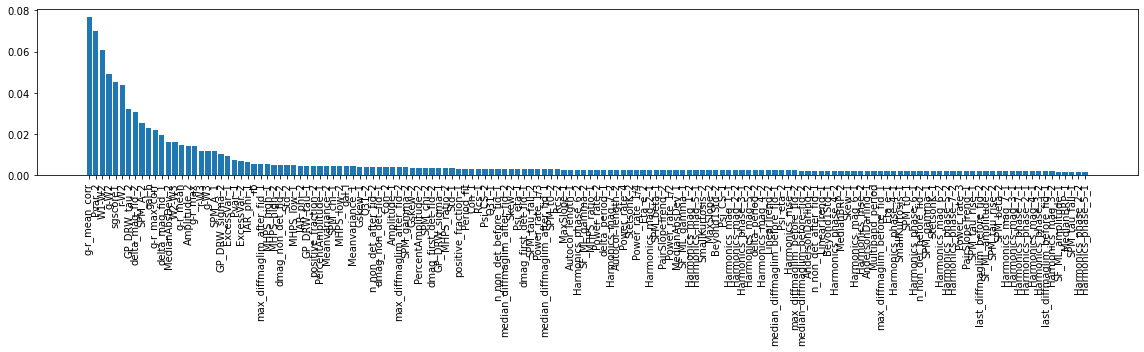

In [17]:
#plotting feature importance
plot_feature_importances(exgb_stochastic, features_stochastic, feature_importance_name_stochastic_layer)

  ### Transient layer

In [18]:
#Training Transient layer

exgb_transient = XGBClassifier(
   max_depth=7,
   min_child_weight=1,
   learning_rate=0.1,
   n_estimators=500,
   silent=False,
   objective='multi:softmax',
   gamma=0,
   max_delta_step=0,
   subsample=0.7,
   colsample_bytree=0.7,
   reg_alpha=0,
   reg_lambda=0,
   scale_pos_weight=1,
   missing=-999,
   n_jobs=5,
)

ros = RandomOverSampler(sampling_strategy='all')
N_samplers=1
out_sampler_X = []
out_sampler_Y = []

for i in range(N_samplers):
    X_resampled, y_resampled = ros.fit_resample(X_train_transient, y_train_transient_encoded)
    X_resampled_df = pd.DataFrame(X_resampled,columns=X_train_hierarchical.columns)
    out_sampler_X.append(X_resampled_df)
    out_sampler_Y.append(y_resampled)
    
df_final_X = pd.concat(out_sampler_X)
y_resampled_final=np.array(out_sampler_Y).flatten()
print(y_resampled_final)    
print(sorted(Counter(y_resampled_final).items()))



exgb_transient.fit(df_final_X, y_resampled_final)




# Applying periodic model to the test data
y_true_transient, y_pred_transient = le_original.transform(y_test_original), exgb_transient.predict(X_test_transient)
y_pred_proba_transient = exgb_transient.predict_proba(X_test_transient)

[13 13 12 ... 13 13 13]
[(10, 1018), (11, 1018), (12, 1018), (13, 1018)]
[18:30:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [19]:
classes_order_proba_transient = exgb_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': exgb_transient,
            'features': features_transient,
            'order_classes': classes_order_proba_transient
            }
        pickle.dump(model_dump, pickle_file)

[10 11 12 13]


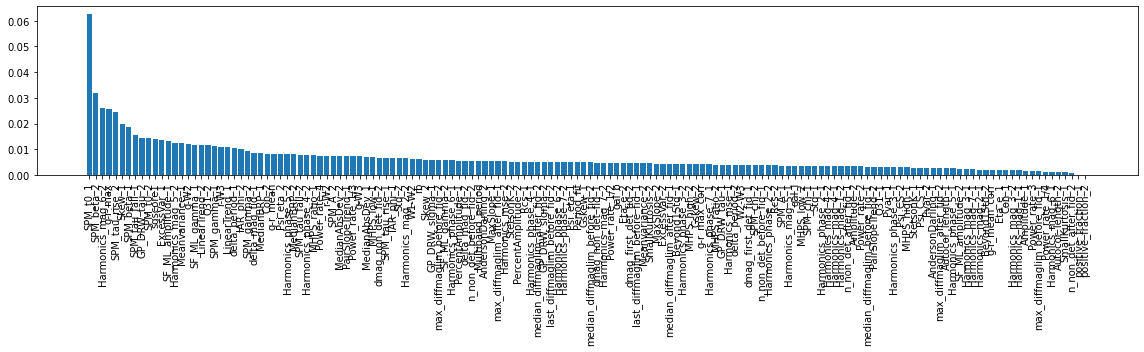

In [20]:
#plotting feature importance
plot_feature_importances(exgb_transient, features_transient, feature_importance_name_transient_layer)

 ## Putting al layers together  


In [21]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]

print(class_final_proba)

[1.         1.         0.99999994 ... 1.         1.         1.        ] 1.0 6.393241e-08
[ 0  1  3  8 14 10 11 12 13  2  4  5  6  7  9]
[0.9999951  0.9985967  0.9996402  ... 0.9999949  0.9997068  0.98971736]


Normalized confusion matrix
[[ 98.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [ 74.   5.  16.   0.   0.   5.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [ 18.   5.  71.   6.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [ 20.   0.  60.  20.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.  94.   6.   0.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.  14.  85.   1.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.  26.   7.  67.   0.   0.   0.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.  89.   0.   3.   4.   0.   1.   2.
    0.]
 [  2.   0.   0.   0.   0.   0.   1.   3.  72.   1.   5.   1.  16.   1.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.
    0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  96.   0.   2.   0.
    1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  13.  83.   3.   0.
    1.]
 [  0.   0. 

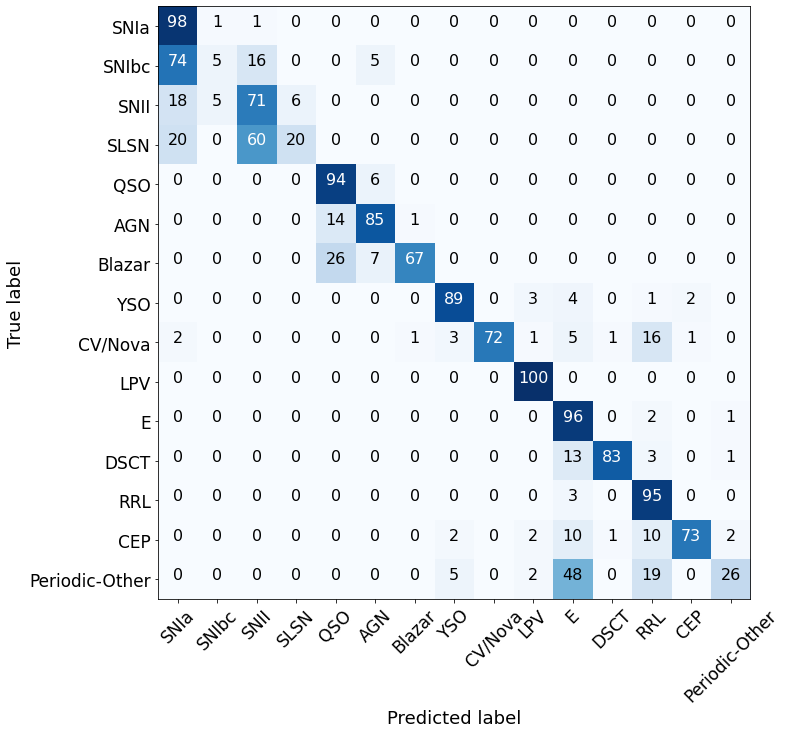

In [22]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, le_original.inverse_transform(class_final_name),labels=label_order)
#print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, '../../paper_late_classifier/paper_plots_2nd_version/conf_matrix_XGBoost.pdf')

print("Accuracy:", metrics.accuracy_score(y_test_original, le_original.inverse_transform(class_final_name)))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, le_original.inverse_transform(class_final_name)))

print("macro precision: ","%0.3f" %  metrics.precision_score(y_test_original, le_original.inverse_transform(class_final_name), average='macro'))
print("macro recall: ","%0.3f" %  metrics.recall_score(y_test_original, le_original.inverse_transform(class_final_name), average='macro'))
print("macro F1: ","%0.3f" %  metrics.f1_score(y_test_original, le_original.inverse_transform(class_final_name), average='macro'))

print(metrics.classification_report(y_test_original, le_original.inverse_transform(class_final_name), digits=3))

In [23]:
# Kaggle score

num_y_test =  [np.where(le_original.inverse_transform(prob_final_class_names)==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))

print(class_weights)

CLASSES_REDUCED_V2 = prob_final_class_names

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final,class_weights))

[6.432283464566929, 85.98947368421052, 24.754545454545454, 326.76, 0.3121513183034008, 1.7511254019292604, 6.4577075098814225, 4.694827586206896, 9.389655172413793, 0.5803907637655418, 0.2155124653739612, 11.19041095890411, 0.2514699091888564, 13.175806451612903, 28.16896551724138]
0 -3.3629206635351254
1 -181.77396385544225
3 -33.86395334980705
8 -71.90844350874424
14 -0.13031618561414893
10 -6.099071314863837
11 -6.517129047397568
12 -0.3646977359107856
13 -45.18575892119572
2 -0.743243817664802
4 -0.15803728843329684
5 -1.7585772546799217
6 -0.005211072324403749
7 -53.548319963485966
9 -4.666045028587868
0.7884378191479146


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['SNIa', 'SNIbc', 'SNII', 'SLSN', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nova', 'LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other'], y=oid
ZTF18abfnksr    RRL
ZTF19abjaesy    QSO
ZTF17aaaiwbh    RRL
ZTF18aaaegfd    RRL
ZTF18aagrhwr    RRL
               ... 
ZTF19aayunul    RRL
ZTF18abmouce    RRL
ZTF18aaadwxx      E
ZTF18acckyvq      E
ZTF18abtsddf    QSO
Name: class_original, Length: 24507, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


  ## Analysis post classification in training set

In [24]:
oids_test = y_test_original.copy()#.index.values
oids_test = oids_test.to_frame()
classified_names = np.array(class_final_name)

oids_test['pred_class'] = classified_names

print(oids_test.head())

LPV_asAGN = oids_test.loc[(oids_test.class_original=='AGN-I') & (oids_test.pred_class=='QSO-I')].index.values
#LPV_asAGN = y_test_original.loc[y_test_original.values=='QSO-I']


print(LPV_asAGN) 

print(df.loc[LPV_asAGN])
test_csv = df.loc[LPV_asAGN]
test_csv.to_csv('~/Desktop/blazar_class_as_QSO.csv')


             class_original  pred_class
oid                                    
ZTF18abfnksr            RRL           9
ZTF19abjaesy            QSO           8
ZTF17aaaiwbh            RRL           9
ZTF18aaaegfd            RRL           9
ZTF18aagrhwr            RRL           9
[]
Empty DataFrame
Columns: [Amplitude_1, Amplitude_2, AndersonDarling_1, AndersonDarling_2, Autocor_length_1, Autocor_length_2, Beyond1Std_1, Beyond1Std_2, Con_1, Con_2, Eta_e_1, Eta_e_2, ExcessVar_1, ExcessVar_2, GP_DRW_sigma_1, GP_DRW_sigma_2, GP_DRW_tau_1, GP_DRW_tau_2, Gskew_1, Gskew_2, Harmonics_mag_1_1, Harmonics_mag_1_2, Harmonics_mag_2_1, Harmonics_mag_2_2, Harmonics_mag_3_1, Harmonics_mag_3_2, Harmonics_mag_4_1, Harmonics_mag_4_2, Harmonics_mag_5_1, Harmonics_mag_5_2, Harmonics_mag_6_1, Harmonics_mag_6_2, Harmonics_mag_7_1, Harmonics_mag_7_2, Harmonics_mse_1, Harmonics_mse_2, Harmonics_phase_2_1, Harmonics_phase_2_2, Harmonics_phase_3_1, Harmonics_phase_3_2, Harmonics_phase_4_1, Harmonics_phase_4_2, H

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


  ## Classifying unlabeled data

In [25]:


mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)


df_feat_ul.head()



,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaavn,0.078912,0.097860,0.847902,0.673712,2.0,1.0,0.380952,0.428571,0.0,0.0,...,0.738809,0.989375,-0.301,1.491,4.239709,2.748709,5.350475,3.859475,0.017990,4.895612e-01
ZTF17aaaadjh,0.493980,0.463765,1.000000,1.000000,1.0,1.0,0.279070,0.293103,0.0,0.0,...,0.742857,1.000000,-0.125,2.380,4.533904,2.153904,5.281445,2.901445,0.000011,5.197596e-08
ZTF17aaaadwo,0.090708,0.196542,0.903625,0.993806,1.0,1.0,0.368421,0.285714,0.0,0.0,...,0.737143,0.992667,-0.065,1.602,4.344352,2.742352,5.495974,3.893974,0.423044,2.662193e-01
ZTF17aaaajjv,0.539600,0.566276,1.000000,1.000000,14.0,20.0,0.419580,0.481203,0.0,0.0,...,0.743333,1.000000,-0.040,0.997,7.765696,6.768696,10.193531,9.196531,29.239637,1.437226e-04
ZTF17aaaakjt,0.564867,0.572449,0.999907,0.990501,1.0,1.0,0.338462,0.350000,0.0,0.0,...,0.818571,0.975000,-0.027,0.027,3.161238,3.134238,4.298826,4.271826,0.000002,2.169809e-06


In [26]:
#predicting classes of unlabeled data


test_Y_hierarchical = exgb_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = exgb_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = exgb_periodic.predict(df_feat_ul)
test_Y_proba_periodic = exgb_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = exgb_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = exgb_stochastic.predict_proba(df_feat_ul)

test_Y_transient = exgb_transient.predict(df_feat_ul)
test_Y_proba_transient = exgb_transient.predict_proba(df_feat_ul)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(le_hierarchical.inverse_transform(classes_order_proba_hierarchical)=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


[1.        1.        1.0000002 ... 1.        1.        1.       ] nan nan
[ 0  1  3  8 14 10 11 12 13  2  4  5  6  7  9]


In [27]:
#Writing results in the output

df_out = df_feat_ul
print(df_out.shape)
#print(class_final_name_ul)
print(len(prob_final_ul))

class_final_name_ul_final = le_original.inverse_transform(class_final_name_ul)

df_out['predicted_class'] = class_final_name_ul_final
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out


probs_header = le_original.inverse_transform(prob_final_class_names) + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

#test_data_withclass.to_csv(class_output)

test_data_withclass.head()


(868371, 152)
868371


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,SNIbc_prob,CEP_prob,DSCT_prob,E_prob,LPV_prob,Periodic-Other_prob,RRL_prob,prob_Periodic,prob_Stochastic,prob_Transient
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaavn,0.078912,0.097860,0.847902,0.673712,2.0,1.0,0.380952,0.428571,0.0,0.0,...,1.021762e-07,0.000066,1.642366e-04,8.819540e-01,0.000511,5.864401e-04,1.650990e-03,0.884932,1.150500e-01,1.801097e-05
ZTF17aaaadjh,0.493980,0.463765,1.000000,1.000000,1.0,1.0,0.279070,0.293103,0.0,0.0,...,1.483205e-10,0.000004,1.904914e-06,9.995789e-01,0.000001,3.101315e-05,3.826714e-04,1.000000,2.224014e-07,3.214533e-08
ZTF17aaaadwo,0.090708,0.196542,0.903625,0.993806,1.0,1.0,0.368421,0.285714,0.0,0.0,...,2.195385e-07,0.000906,1.777010e-04,9.385597e-01,0.000078,1.591299e-04,5.978871e-02,0.999670,3.296002e-04,7.816345e-07
ZTF17aaaajjv,0.539600,0.566276,1.000000,1.000000,14.0,20.0,0.419580,0.481203,0.0,0.0,...,4.520377e-10,0.000020,1.875975e-08,7.506271e-07,0.999978,5.587246e-08,3.425357e-08,0.999999,7.902408e-07,1.205026e-07
ZTF17aaaakjt,0.564867,0.572449,0.999907,0.990501,1.0,1.0,0.338462,0.350000,0.0,0.0,...,2.637510e-10,0.000023,8.013763e-05,9.998270e-01,0.000002,5.557010e-05,1.126196e-05,0.999999,8.225837e-07,9.410964e-08


In [28]:
test_data_withclass.shape
#class_final_name_ul = le_original.inverse_transform(class_final_name_ul)

(868371, 172)

Counter({'E': 436265, 'LPV': 203586, 'RRL': 87734, 'QSO': 49233, 'YSO': 38201, 'CEP': 13582, 'AGN': 12918, 'DSCT': 7881, 'CV/Nova': 5916, 'SNIa': 4914, 'Periodic-Other': 3723, 'Blazar': 2704, 'SNII': 1524, 'SNIbc': 135, 'SLSN': 55})
                number
E               436265
LPV             203586
RRL              87734
QSO              49233
YSO              38201
CEP              13582
AGN              12918
DSCT              7881
CV/Nova           5916
SNIa              4914
Periodic-Other    3723
Blazar            2704
SNII              1524
SNIbc              135
SLSN                55


Text(0, 0.5, '$\\#$ of classifiead sources')

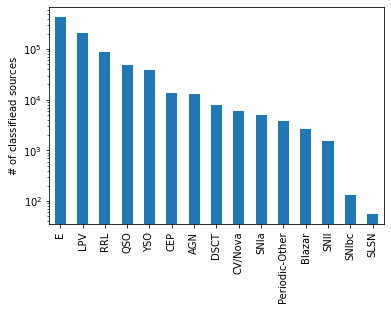

In [29]:
class_counts = Counter(class_final_name_ul_final)
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)

#plt.bar(class_counts.keys(), class_counts.values())
plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of classifiead sources')
#plt.xlabel(r'class')
#df_hist.set_xticklabels(label_order)

0 SNIa 0.9999908804893494
1 SNIbc 0.9999972581863403
2 SNII 0.9999145269393921
3 SLSN 0.999992847442627
4 QSO 0.9999996423721313
5 AGN 0.9999973773956299
6 Blazar 0.9999880194664001
7 YSO 0.9240186214447021
8 CV/Nova 0.9867694973945618
9 LPV 0.9998455047607422
10 E 0.9998761415481567
11 DSCT 0.9999867677688599
12 RRL 0.9999860525131226
13 CEP 0.9986128807067871
14 Periodic-Other 0.9997780919075012


Text(0.5, 0, 'Predicted hierarchical level probability ($\\mathcal{P}_{H_{BHRF}}$)')

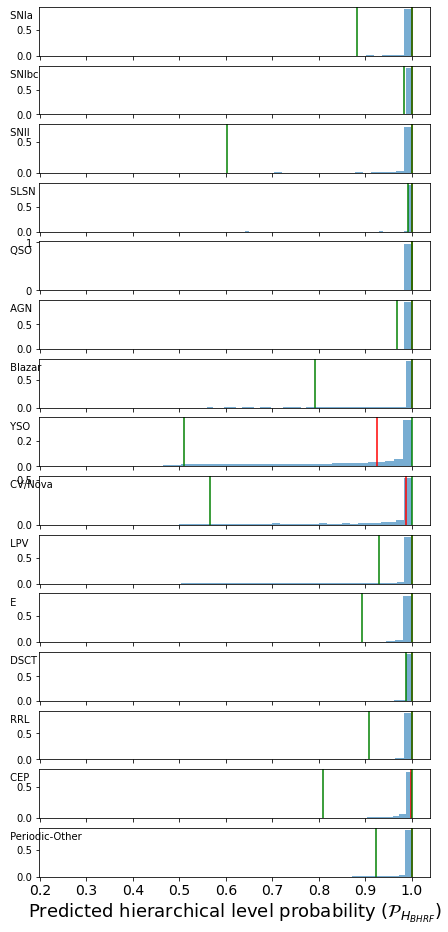

In [30]:
#plotting hierarchical level probabilities
label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   if cl=="QSO" or cl=="AGN" or cl=='YSO' or cl=='CV/Nova' or cl=="Blazar":
        prob = 'prob_Stochastic'
   elif cl=="SNIa" or cl=="SNIbc" or cl=='SNII' or cl=='SLSN':
        prob = 'prob_Transient'
   else:      
        prob = 'prob_Periodic'
        
   print(idx, cl, np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="LPV"): 
       ax[idx].text(0.13, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
   else: 
       ax[idx].text(0.13, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')


plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted hierarchical level probability ($\mathcal{P}_{H_{BHRF}}$)',fontsize=18)

0 SNIa 0.9957499206066132
1 SNIbc 0.9986961483955383
2 SNII 0.9512052536010742
3 SLSN 0.8853618502616882
4 QSO 0.9993724226951599
5 AGN 0.9954381287097931
6 Blazar 0.9954351484775543
7 YSO 0.9001627564430237
8 CV/Nova 0.9638148546218872
9 LPV 0.999470591545105
10 E 0.9920085072517395
11 DSCT 0.9692075252532959
12 RRL 0.9938481450080872
13 CEP nan


/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/psanchez/.local/lib/python3.7/site-packages/numpy-1.17.4-py3.7-macosx-10.9-x86_64.egg/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


14 Periodic-Other 0.6894500255584717


Text(0.5, 0, 'Predicted multi-class level probability ($\\mathcal{P}_{MC_{BHRF}}$)')

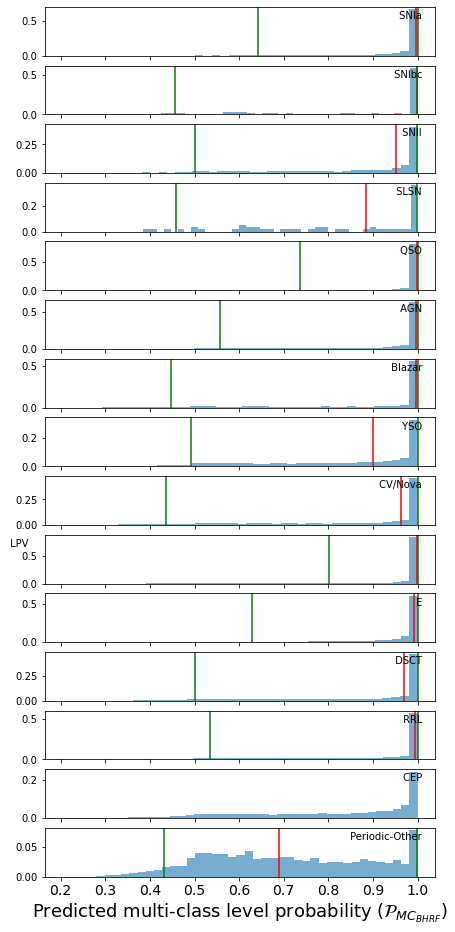

In [31]:
#plotting multi-class level probabilities

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="LPV"): 
       ax[idx].text(0.08, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
   else: 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')

plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted multi-class level probability ($\mathcal{P}_{MC_{BHRF}}$)',fontsize=18)

[ 0.28745954  0.01148621 -0.41500643 ... -0.03133921  1.16290611
  0.50610879]


[Text(1, 0, '0.2'),
 Text(1, 0, '0.3'),
 Text(1, 0, '0.4'),
 Text(1, 0, '0.5'),
 Text(1, 0, '0.6'),
 Text(1, 0, '0.7')]

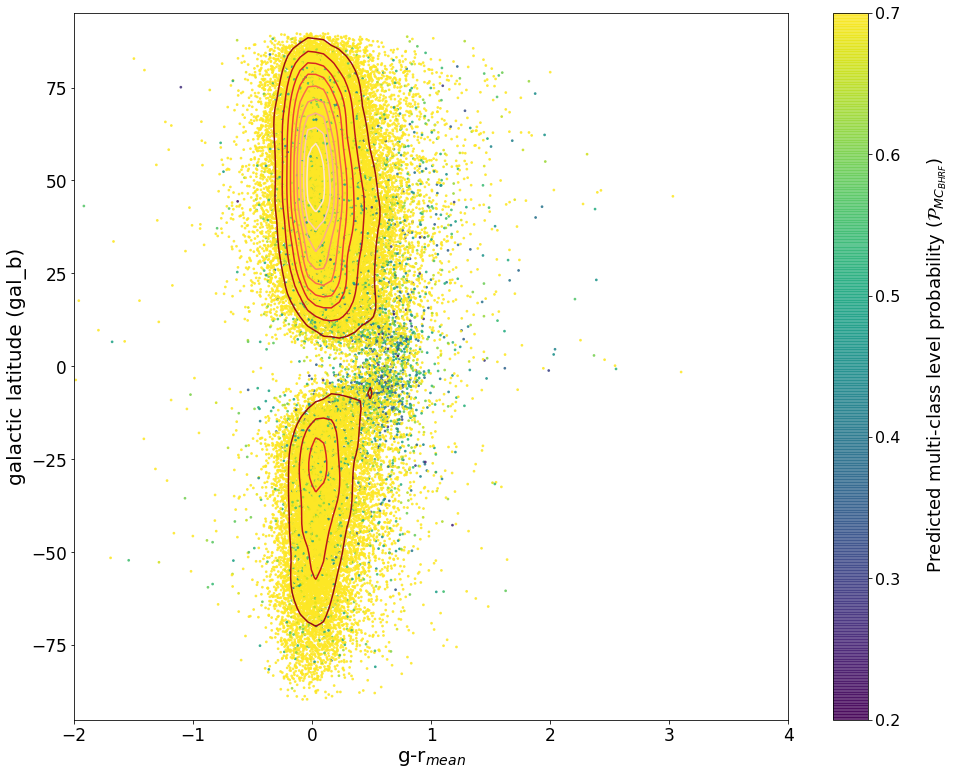

In [32]:
import matplotlib.cm as cm
import seaborn as sns

feature_x = 'g-r_mean'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
color_list = []

for idx, cl in enumerate(labels_list):
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   color_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
    
gal_b_array = np.array(gal_b_list)
color_array = np.array(color_list)

print(color_array)

ax = sns.kdeplot(color_array,gal_b_array, n_levels=10, cmap="Reds_r", shade=False)
    
cbar = plt.colorbar(sc)
cbar.set_label('\n Predicted multi-class level probability ($\mathcal{P}_{MC_{BHRF}}$) ', rotation=90,fontsize=18)

#plt.legend(fontsize=15)
plt.xlabel(r'g-r$_{mean}$',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

[ 90.84914758 172.52388507  94.20044171 ... 106.50580561 139.61568137
 171.70772968]


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.]),
 <a list of 9 Text major ticklabel objects>)

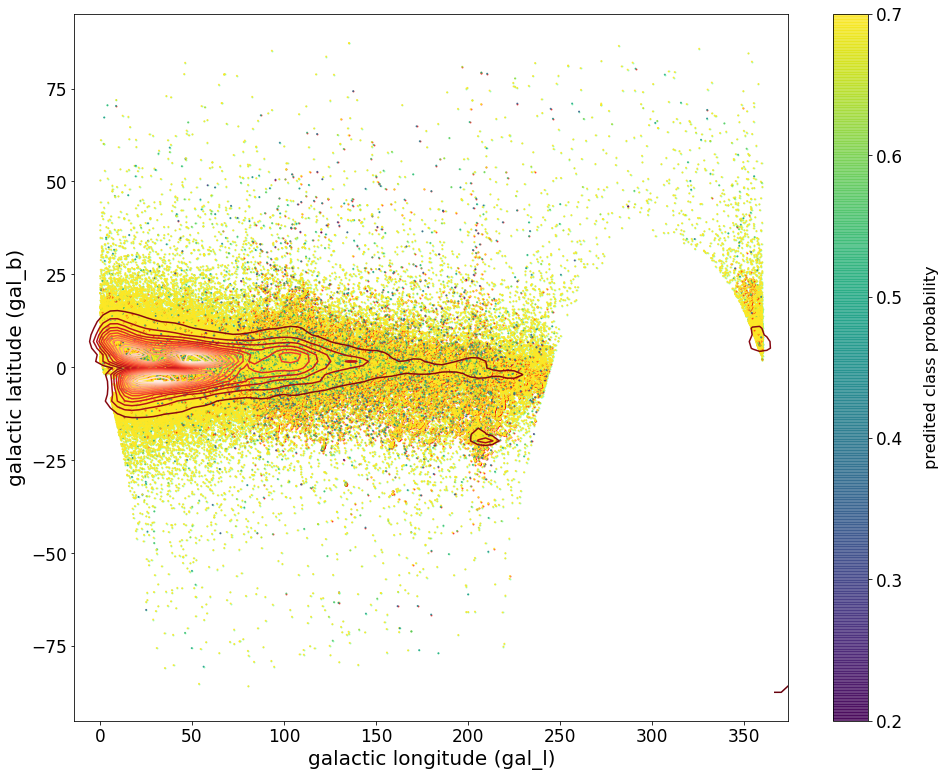

In [33]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['Ceph','LPV','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

